In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import seaborn as sns
import pandas as pd

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_model_name(key):
    if key == 'rnn_dynamiclr':
        return 'RNN with Dynamic LR'
    elif key == 'rnn_fixedlr':
        return 'RNN with Fixed LR'
    elif key == 'linear':
        return 'Linear'
    elif key == 'mlp':
        return 'MLP with Replay Buffer'
    else:
        raise ValueError("Invalid key.")

In [76]:
def format_dset_name(key):
    if key == 'comp_1':
        return 'Compression with {0,1} Values'
    elif key == 'same_1':
        return 'Same with {0,1} Values'
    elif key == 'exp_1':
        return 'Expansion with {0,1} Values'
    elif key == 'comp_05':
        return 'Compression with {0, 0.5, 1} Values'
    elif key == 'same_05':
        return 'Same with {0, 0.5, 1} Values'
    elif key == 'exp_05':
        return 'Expansion with {0, 0.5, 1} Values'
    else:
        raise ValueError("Invalid key.")

In [77]:
def get_dset_ylim(key):
    if '1' in key:
        return [0.03, 0.07]
    elif '0.5' in key:
        return [0.02, 0.06]
    elif '0.2' in key:
        return [0.015, 0.055]
    else:
        raise ValueError("Invalid key.")

In [78]:
def plot(steps, losses, models, figname):
    df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
    fig, ax = plt.subplots(figsize=(2.75*2, 2*2)) # width, height default (6.4, 2.8)
    sns.lineplot(x='Steps into Walk', y='TD Error', hue='Model', data=df, ax=ax)
    plt.xlabel('') #'Steps into Walk', fontsize=14)
    plt.ylabel('') #'TD Error', fontsize=14)
    plt.title('') #format_dset_name(figname), fontsize=16)
    ylim = get_dset_ylim(figname)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.tight_layout()
    plt.savefig('td_discrete_uncorr_' + figname + '.png', dpi=100)
    plt.show()

comp_0.2


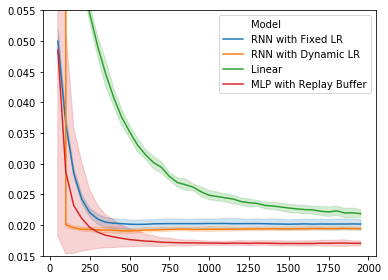

exp_1


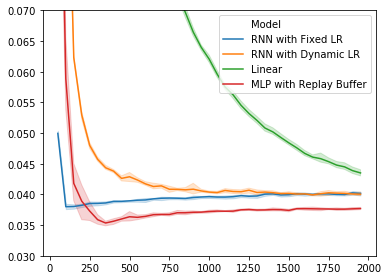

comp_1


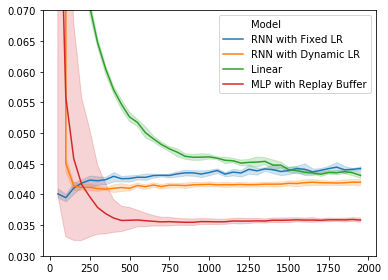

same_0.2


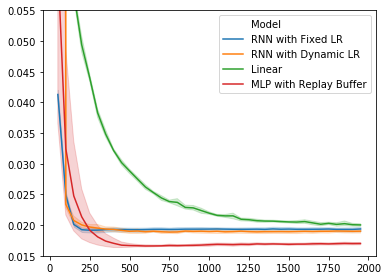

exp_0.2


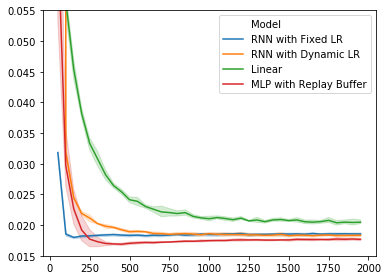

comp_0.5


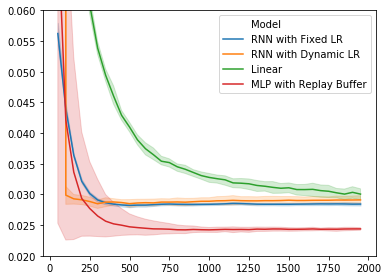

exp_0.5


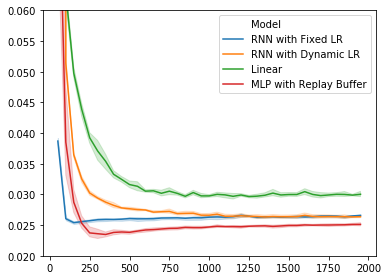

same_1


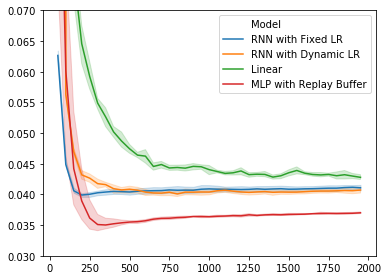

same_0.5


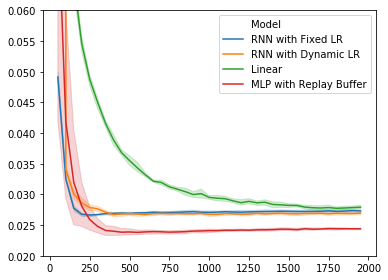

In [79]:
experiment_dir = "../trained_models/03_td_discrete_uncorr/"

for dset in os.listdir(experiment_dir):
    print(dset)
    dset_dir = experiment_dir + dset + '/'
    
    steps = []
    losses = []
    models = []
    for model in os.listdir(dset_dir):
        model_dir = dset_dir + model + '/'
        try:
            model_name = format_model_name(model)
        except:
            continue # Not a directory we care about
        for _iter in os.listdir(model_dir):
            iter_dir = model_dir + _iter + '/'
            for file in os.listdir(iter_dir):
                if 'tfevents' not in file: continue
                tfevents_file = iter_dir + '/' + file
                event_acc = EventAccumulator(tfevents_file)
                event_acc.Reload()
                scalar_events = event_acc.Scalars('loss_train')
                for i in range(len(scalar_events)):
                    steps.append(scalar_events[i].step)
                    losses.append(scalar_events[i].value)
                    models.append(model_name)
                break
    steps = np.array(steps)
    losses = np.array(losses)
    models = np.array(models)
    
    plot(steps, losses, models, dset)